In [167]:
using Plots, PlotThemes, LaTeXStrings
using OffsetArrays
using SparseArrays
using FFTW
using StatsBase
using Unitful
using Base: Fix1, Fix2
using Distributions


theme(:juno)
default(;palette=:seaborn_pastel6, background_color="#1b3041")
j=im

im

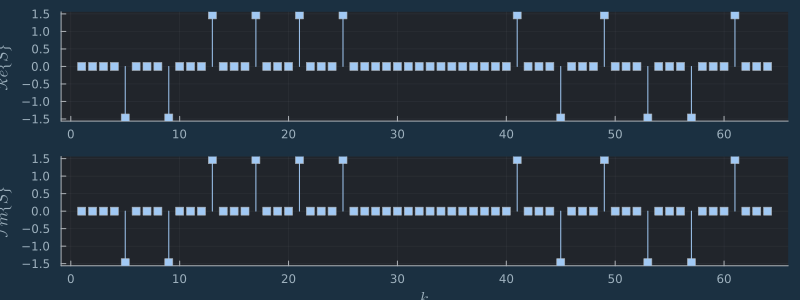

In [168]:
S = OffsetArray(sqrt(13/6).*[0, 0, 1+j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, -1-j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, 0,
0, 0, 0, -1-j, 0, 0, 0, -1-j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0, 0, 0, 1+j, 0,0], -26:26)
r_s(t) = w(T_SHORT,t)*sum(S[k]*exp(j*k*2π*Δ_F*t) for k in eachindex(S))

shift(x) = [i in 1:26 ? x[i] : (i in 38:63 ? x[i-64] : 0.0+im*0.0) for i in 0:63]

p1 = plot(S |> shift |> real, line=:stem, marker=:square, ylabel=L"\mathcal{Re}\{S\}")
p2 = plot(S |> shift |> imag, line=:stem, marker=:square, ylabel=L"\mathcal{Im}\{S\}", xlabel=L"k")

plot(p1, p2, layout=(2,1), legend=false, size=(800,300), background_color="#1b3041")

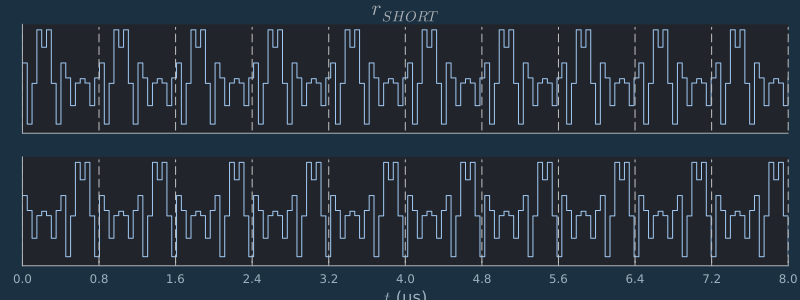

In [169]:
S_time = S |> shift |> ifft

tiks = [0:0.8:8...]

t = range(0u"μs", 8u"μs", length=160)

str_t = vcat(repeat(S_time[1:16],10)...)

p1 = plot(t, real(str_t), xlim=[0,8], yticks=false, line=:steppost, ylabel="canal I", xlabel="", xticks=[], title=L"r_{SHORT}")
p2 = plot(t, imag(str_t), xlim=[0,8], yticks=false, line=:steppost, ylabel="canal Q", xticks=tiks, xlabel=L"t")

for i in tiks
    plot!(p1, [i,i], [-0.15,0.15], linestyle=:dash, linecolor=:silver)
    plot!(p2, [i,i], [-0.15,0.15], linestyle=:dash, linecolor=:silver)
end

plot(p1, p2, layout=(2,1), legend = false, size=(800,300), background_color="#1b3041")

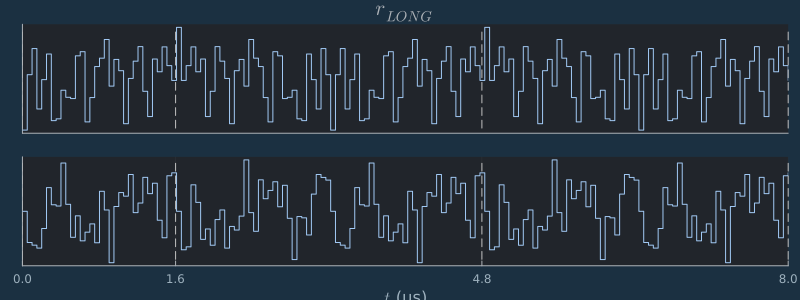

In [170]:
L = OffsetArray([1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 0,
1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0] .|> Complex, -26:26) 


L_time = L |> shift |> ifft

p1 = plot(L_time |> real, line=:stem, marker=:square, ylabel=L"\mathcal{Re}\{L\}")
p2 = plot(L_time |> imag, line=:stem, marker=:square, ylabel=L"\mathcal{Im}\{L\}", xlabel=L"k")

tiks = [0, 1.6,4.8,8]

t = range(0u"μs", 8u"μs", length=160)


ltr_t = vcat(L_time[end-31:end], L_time, L_time)

p1 = plot(t, real(ltr_t), xlim=[0,8], yticks=false, line=:steppost, ylabel="canal I", xlabel="", xticks=[], title=L"r_{LONG}")
p2 = plot(t, imag(ltr_t), xlim=[0,8], yticks=false, line=:steppost, ylabel="canal Q", xticks=tiks, xlabel=L"t")

for i in tiks
    plot!(p1, [i,i], [-0.15,0.15], linestyle=:dash, linecolor=:silver)
    plot!(p2, [i,i], [-0.15,0.15], linestyle=:dash, linecolor=:silver)
end
plot(p1, p2, layout=(2,1), legend = false, size=(800,300), background_color="#1b3041")

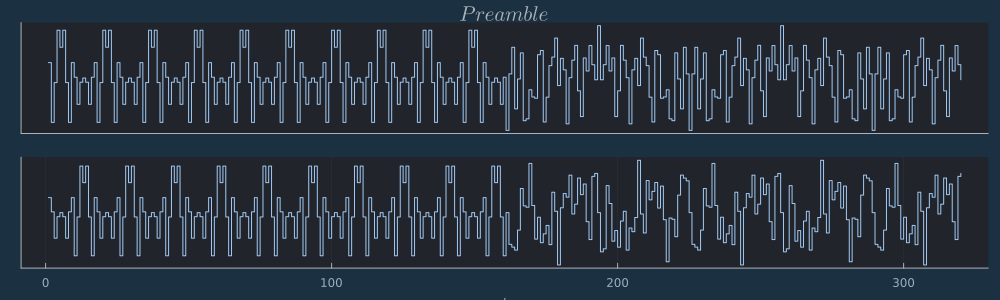

In [171]:
sym = vcat(str_t, ltr_t)

p1 = plot(real(sym), yticks=false, line=:steppost, ylabel="canal I", xlabel="", xticks=[], title=L"Preamble")
p2 = plot(imag(sym), yticks=false, line=:steppost, ylabel="canal Q", xlabel=L"t")

plot(p1, p2, layout=(2,1), legend = false, size=(1000,300), background_color="#1b3041")

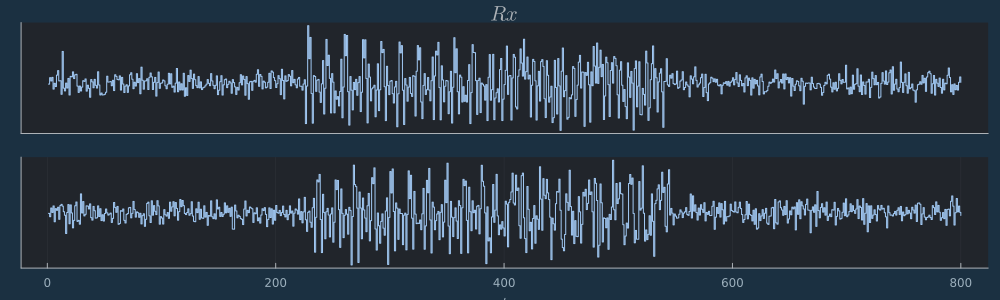

In [172]:
N = 800
start_t = mod(rand(Int),300)+100
d = Normal(0, 0.025)

y = vcat(zeros(start_t), sym, zeros(800-start_t-length(sym))) .+ rand(d, 800) .+ j.*rand(d, 800)


p1 = plot(real(y), yticks=false, line=:steppost, ylabel="canal I", xlabel="", xticks=[], title=L"Rx")
p2 = plot(imag(y), yticks=false, line=:steppost, ylabel="canal Q", xlabel=L"t")

plot(p1, p2, layout=(2,1), legend = false, size=(1000,300), background_color="#1b3041")

In [173]:
function delay_and_correlate(y, idx, R, L)
    x1 = y[idx:idx+R]
    x2 = y[idx+L:idx+R+L]
    e = maximum(crosscor(x1,x2))
    return isnan(e) ? 0 : e
end

delay_and_correlate (generic function with 1 method)

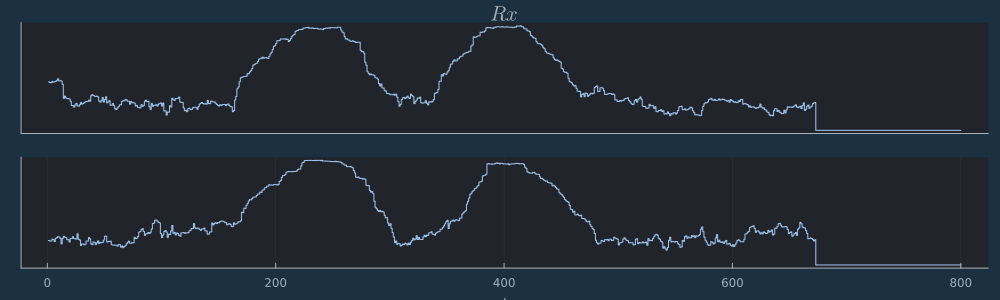

In [174]:
R=64
L=R
est2r = vcat([delay_and_correlate(real(y), i, R,L) for i in 1:800-R-L], zeros(R+L))
est2i = vcat([delay_and_correlate(imag(y), i, R,L) for i in 1:800-R-L], zeros(R+L))

p1 = plot(est2r, yticks=false, line=:steppost, ylabel="canal I", xlabel="", xticks=[], title=L"Rx")
p2 = plot(est2i, yticks=false, line=:steppost, ylabel="canal Q", xlabel=L"t")

plot(p1, p2, layout=(2,1), legend = false, size=(1000,300), background_color="#1b3041")

In [196]:
function short_correlate(y, idx, str_t)
    x1 = y[idx:idx+length(str_t)-1]
    @info length(str_t)
    @info length(x1)
    e = cor(x1,str_t)
    return isnan(e) ? 0 : e
end

short_correlate (generic function with 1 method)

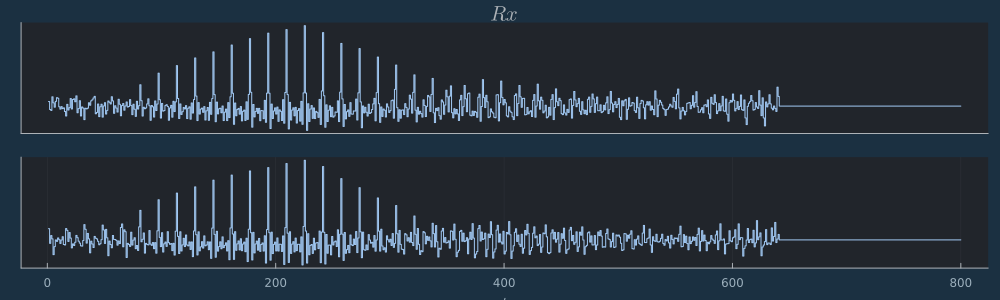

In [197]:
R=64
L=R
est2r = vcat([short_correlate(real(y), i, real(str_t)) for i in 1:800-length(str_t)], zeros(length(str_t)))
est2i = vcat([short_correlate(imag(y), i, imag(str_t)) for i in 1:800-length(str_t)], zeros(length(str_t)))

p1 = plot(est2r, yticks=false, line=:steppost, ylabel="canal I", xlabel="", xticks=[], title=L"Rx")
p2 = plot(est2i, yticks=false, line=:steppost, ylabel="canal Q", xlabel=L"t")

plot(p1, p2, layout=(2,1), legend = false, size=(1000,300), background_color="#1b3041")